# Import

In [15]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models.segmentation as segmentation
import segmentation_models_pytorch as smp
import torchvision.models as models
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transforms
from albumentations.core.composition import Compose
from sklearn.metrics import f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Fuctions

## RLE decoding/encoding

In [16]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Model save/load

In [17]:
save_dir = "./path/save/v3plus_resnet_mobilenet/"  # 모델 저장 디렉토리
model_name = "v3plus_resnet50_mobilenet_trained_epoch{}.pth"  # 모델 파일 이름 패턴

# 훈련된 모델을 저장하는 함수
def save_model(model, epoch):
    save_path = save_dir + model_name.format(epoch)
    torch.save(model.state_dict(), save_path)
    print(f"Epoch {epoch} 모델 저장이 완료되었습니다.")

# 모델 불러오는 함수
def load_model(model, load_path):
    state_dict = torch.load(load_path)
    # 이전에 저장된 모델과 현재 모델 간 레이어 일치 여부 확인
    model_dict = model.state_dict()
    new_state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
    model_dict.update(new_state_dict)
    model.load_state_dict(model_dict)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print("모델 불러오기가 완료되었습니다.")

## Custom Dataset

In [18]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False): # transform 전처리하거나 다른 형태로 변환하는데 사용, infer 데이터를 추론 모드로 설정할지 여부
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1] # 해당 인덱스에 위치한 데이터프레임의 두 번째 열(column)에 있는 이미지 경로를 가져옴
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2] # 데이터프레임의 idx 행에서 세 번째 열(column)에 있는 마스크 정보를 가져옴
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1])) # 원래의 마스크 이미지로 변환

        if self.transform:
            augmented = self.transform(image=image, mask=mask) # 이미지와 마스크를 변환
            image = augmented['image'] # 변환된 이미지를 딕셔너리에서 가져와 image 변수에 할당
            mask = augmented['mask'] # 변환된 이미지를 딕셔너리에서 가져와 mask 변수에 할당
            # print(type(image),type(mask))
        return image, mask

## Loss Function

In [19]:
class FocalDiceLoss(nn.Module):
    def __init__(self, gamma=2, smooth=1e-6):
        super(FocalDiceLoss, self).__init__()
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Focal Loss 계산
        inputs_prob = torch.sigmoid(inputs)
        focal_loss = -targets * (1 - inputs_prob) ** self.gamma * torch.log(inputs_prob + self.smooth) \
                     - (1 - targets) * inputs_prob ** self.gamma * torch.log(1 - inputs_prob + self.smooth)
        focal_loss = focal_loss.mean()

        # Dice Loss 계산
        dice_target = targets
        dice_output = inputs_prob
        intersection = (dice_output * dice_target).sum()
        union = dice_output.sum() + dice_target.sum()
        dice_loss = 1 - (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Focal Loss와 Dice Loss를 더해서 총 손실을 계산
        total_loss = focal_loss + dice_loss

        return total_loss

## Ensemble Model Define

In [20]:
# # class EnsembleModel(nn.Module):
# #     def __init__(self, resnet_model, mobilenet_model):
# #         super(EnsembleModel, self).__init__()
# #         self.resnet_model = resnet_model
# #         self.mobilenet_model = mobilenet_model

# #     def forward(self, x):
# #         resnet_out = self.resnet_model(x)
# #         mobilenet_out = self.mobilenet_model(x)

# #         # 각 모델의 출력 채널 수를 맞춰주는 작업
# #         resnet_out = resnet_out['out']
# #         mobilenet_out = mobilenet_out['out']

# #         # 앙상블된 출력을 처리
# #         combined_out = resnet_out + mobilenet_out

# #         return combined_out

# class EnsembleModel(nn.Module):
#     def __init__(self, resnet_model, mobilenet_model):
#         super(EnsembleModel, self).__init__()
#         self.resnet_model = resnet_model
#         self.mobilenet_model = mobilenet_model

#     def forward(self, x):
#         resnet_out = self.resnet_model(x)
#         mobilenet_out = self.mobilenet_model(x)

#         # 각 모델의 출력 채널 수를 맞춰주는 작업
#         resnet_out = resnet_out[0]
#         mobilenet_out = mobilenet_out[0]

#         # 앙상블된 출력을 처리
#         combined_out = resnet_out + mobilenet_out

#         return combined_out


## Calculate F1-Score

In [21]:
# def calculate_f1_score(outputs, masks):
#     # outputs: 모델의 출력 (확률 값)
#     # masks: 정답 마스크
    
#     predicted_masks = (torch.sigmoid(outputs) > 0.5).float()
#     predicted_masks = predicted_masks.view(-1)
#     masks = masks.view(-1)

#     f1 = f1_score(masks.cpu().numpy(), predicted_masks.cpu().numpy())
#     return f1

# Model Define

In [22]:
# 모델 1: resnet50
model1 = smp.DeepLabV3Plus(encoder_name="resnet50", in_channels=3, classes=1, encoder_weights="imagenet")

# 모델 2: 다른 모델 (예를 들어, mobilenetv3_large)
model2 = smp.DeepLabV3Plus(encoder_name="timm-mobilenetv3_large_100", in_channels=3, classes=1, encoder_weights="imagenet")

# 각 모델을 GPU로 이동
model1 = model1.to(device)
model2 = model2.to(device)

criterion = FocalDiceLoss()

# 옵티마이저 설정
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001, weight_decay=1e-3) 
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001, weight_decay=1e-3) 

# Model Train

In [23]:
#그래프 생성 리스트 초기화
train_losses = []
val_losses = []

train_f1_scores = []
val_f1_scores = []

100%|██████████| 893/893 [06:18<00:00,  2.36it/s]


Epoch 1 모델 저장이 완료되었습니다.
Epoch 1, Training Loss: 0.5711923164189329, Training Accuracy: 0.9511790318806094, Validation Loss: 0.5623187351226807, Validation Accuracy: 0.9479647640306123


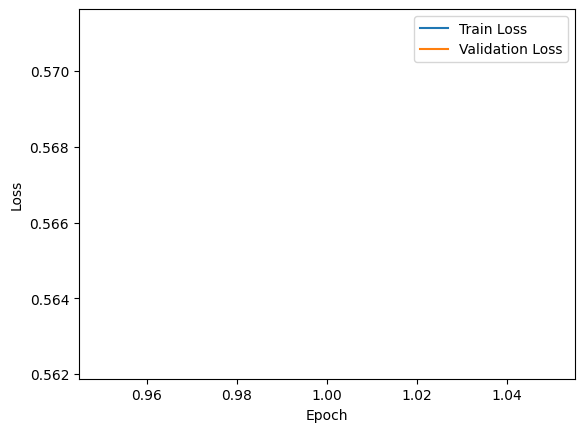

100%|██████████| 893/893 [06:27<00:00,  2.31it/s]


Epoch 2 모델 저장이 완료되었습니다.
Epoch 2, Training Loss: 0.5006493798896153, Training Accuracy: 0.9604541230554722, Validation Loss: 0.586887047290802, Validation Accuracy: 0.9364694276147959


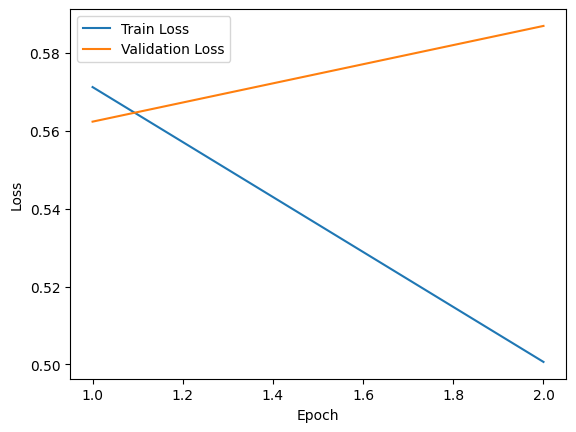

100%|██████████| 893/893 [06:29<00:00,  2.29it/s]


Epoch 3 모델 저장이 완료되었습니다.
Epoch 3, Training Loss: 0.49094132258069745, Training Accuracy: 0.9609056904011605, Validation Loss: 0.5040069103240967, Validation Accuracy: 0.9517103794642857


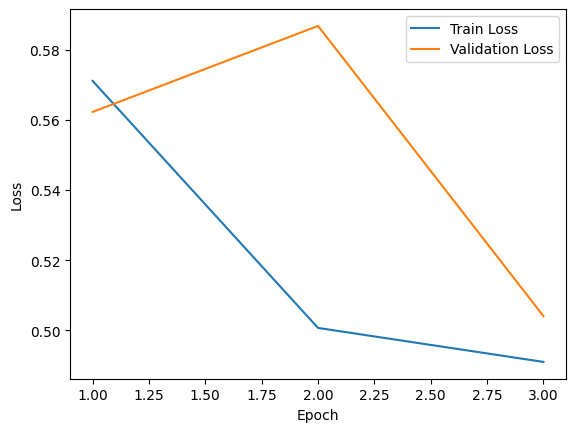

100%|██████████| 893/893 [06:27<00:00,  2.30it/s]


Epoch 4 모델 저장이 완료되었습니다.
Epoch 4, Training Loss: 0.48485785879586873, Training Accuracy: 0.962056239906677, Validation Loss: 0.5481240439414978, Validation Accuracy: 0.9485269850127551


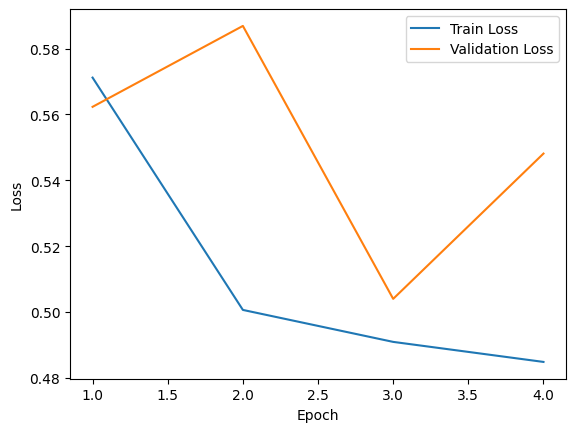

100%|██████████| 893/893 [05:48<00:00,  2.56it/s]


Epoch 5 모델 저장이 완료되었습니다.
Epoch 5, Training Loss: 0.47175758893519204, Training Accuracy: 0.9633831099404048, Validation Loss: 0.5618681311607361, Validation Accuracy: 0.9503852439413265


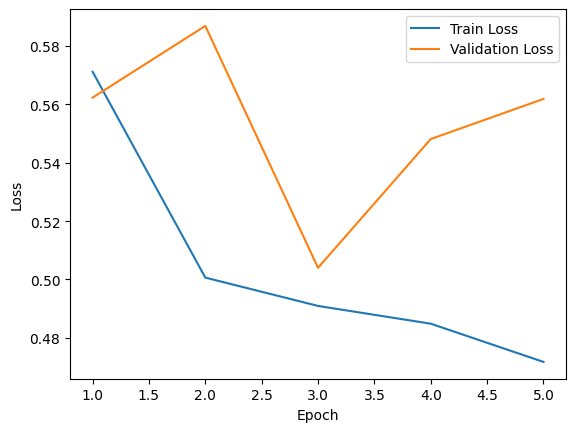

100%|██████████| 893/893 [05:23<00:00,  2.76it/s]


Epoch 6 모델 저장이 완료되었습니다.
Epoch 6, Training Loss: 0.4779238444977218, Training Accuracy: 0.9623031243747499, Validation Loss: 0.5011972665786744, Validation Accuracy: 0.9489578683035714


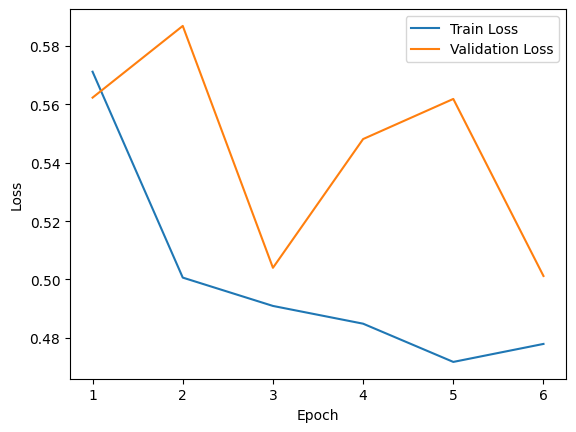

100%|██████████| 893/893 [05:45<00:00,  2.59it/s]


Epoch 7 모델 저장이 완료되었습니다.
Epoch 7, Training Loss: 0.45858594446473266, Training Accuracy: 0.9638658728000129, Validation Loss: 0.5488863968849182, Validation Accuracy: 0.9471167490433674


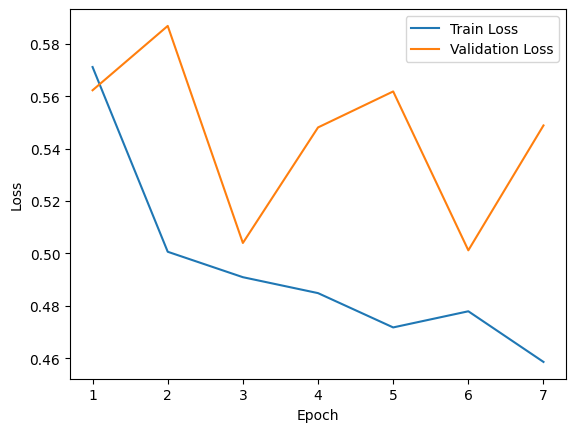

100%|██████████| 893/893 [05:47<00:00,  2.57it/s]


Epoch 8 모델 저장이 완료되었습니다.
Epoch 8, Training Loss: 0.46443208212748355, Training Accuracy: 0.9638365055843766, Validation Loss: 0.5299599504470826, Validation Accuracy: 0.9495886479591836


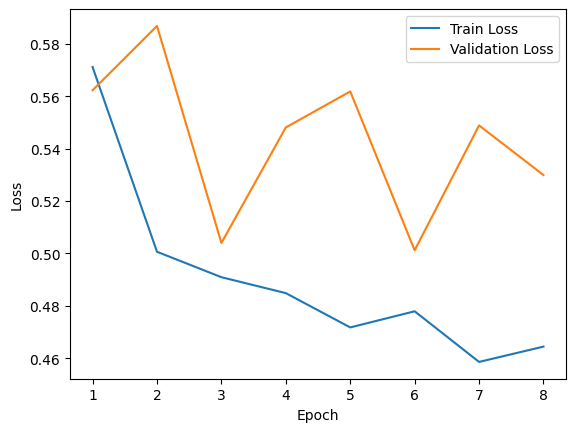

100%|██████████| 893/893 [05:47<00:00,  2.57it/s]


Epoch 9 모델 저장이 완료되었습니다.
Epoch 9, Training Loss: 0.4655206919317149, Training Accuracy: 0.9638250584832148, Validation Loss: 0.7301526498794556, Validation Accuracy: 0.9405187739158163


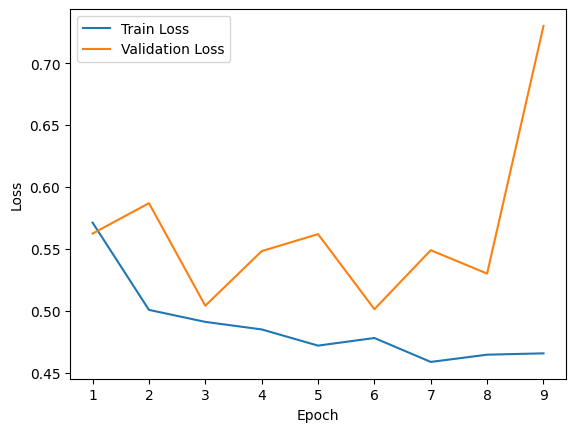

100%|██████████| 893/893 [05:46<00:00,  2.57it/s]


Epoch 10 모델 저장이 완료되었습니다.
Epoch 10, Training Loss: 0.45442176162195363, Training Accuracy: 0.9648418016760275, Validation Loss: 0.5515699326992035, Validation Accuracy: 0.9507150829081633


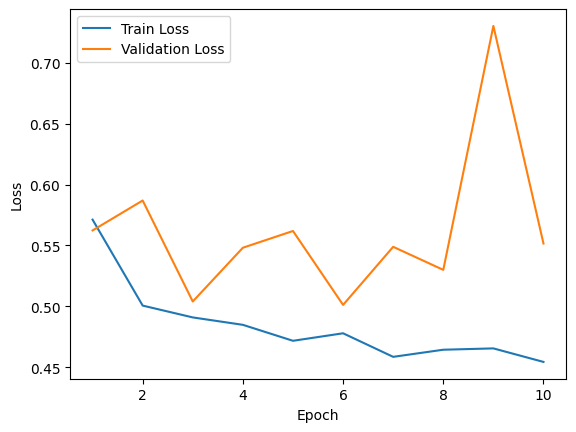

100%|██████████| 893/893 [05:52<00:00,  2.53it/s]


Epoch 11 모델 저장이 완료되었습니다.
Epoch 11, Training Loss: 0.4552600830125916, Training Accuracy: 0.964823222815912, Validation Loss: 0.505229959487915, Validation Accuracy: 0.9483073580994898


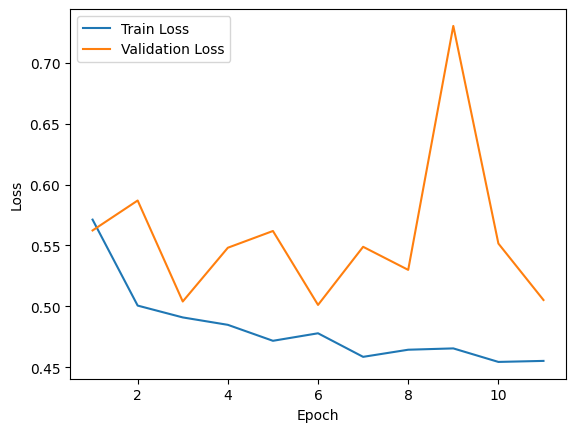

100%|██████████| 893/893 [05:45<00:00,  2.59it/s]


Epoch 12 모델 저장이 완료되었습니다.
Epoch 12, Training Loss: 0.45615840170111127, Training Accuracy: 0.9647523462510004, Validation Loss: 0.4894689011573792, Validation Accuracy: 0.9506106505102041


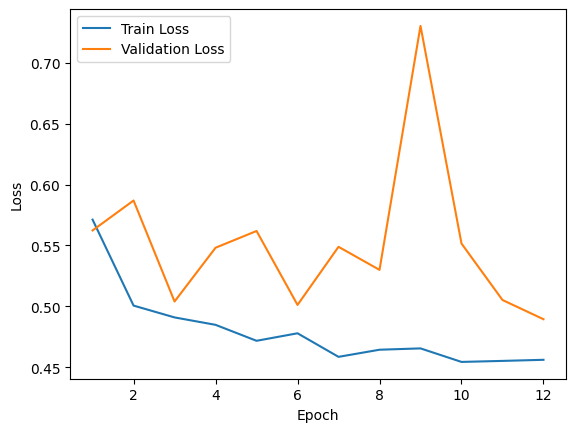

100%|██████████| 893/893 [05:49<00:00,  2.55it/s]


Epoch 13 모델 저장이 완료되었습니다.
Epoch 13, Training Loss: 0.45345070001993576, Training Accuracy: 0.9647275037247042, Validation Loss: 0.49336378574371337, Validation Accuracy: 0.9487715242346939


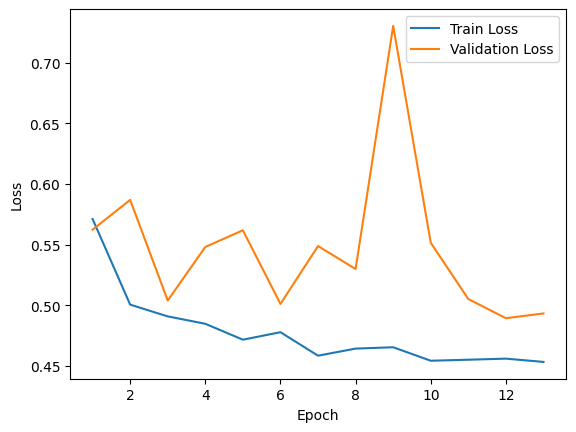

100%|██████████| 893/893 [05:53<00:00,  2.53it/s]


Epoch 14 모델 저장이 완료되었습니다.
Epoch 14, Training Loss: 0.4507013084106189, Training Accuracy: 0.9643262494730035, Validation Loss: 0.5379983854293823, Validation Accuracy: 0.9392745535714285


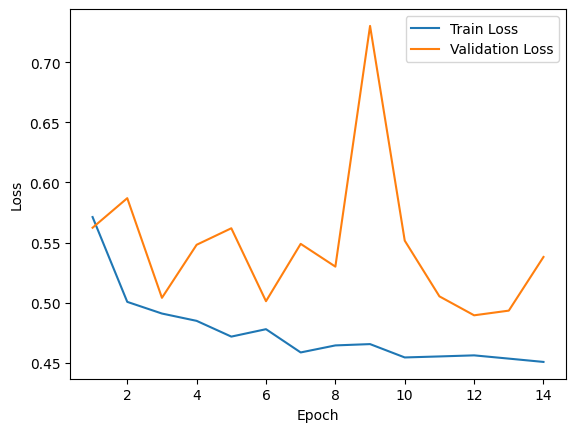

100%|██████████| 893/893 [05:50<00:00,  2.54it/s]


Epoch 15 모델 저장이 완료되었습니다.
Epoch 15, Training Loss: 0.44357902989675857, Training Accuracy: 0.964836073938504, Validation Loss: 0.6233255672454834, Validation Accuracy: 0.9461493542729592


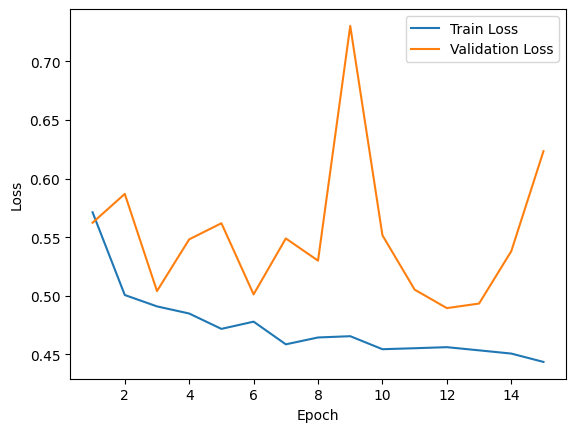

100%|██████████| 893/893 [05:49<00:00,  2.56it/s]


Epoch 16 모델 저장이 완료되었습니다.
Epoch 16, Training Loss: 0.44345792156851704, Training Accuracy: 0.9659316488872335, Validation Loss: 0.47341381072998046, Validation Accuracy: 0.950675422512755


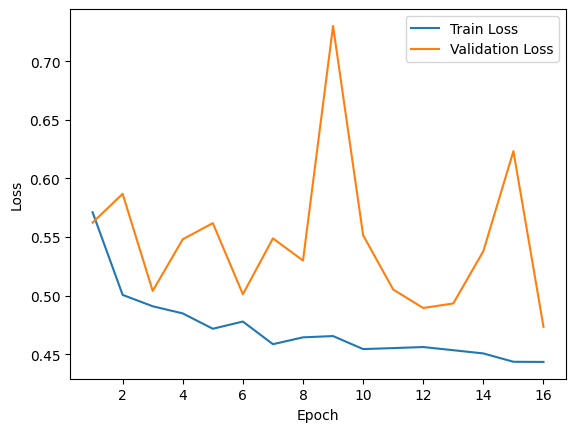

100%|██████████| 893/893 [05:48<00:00,  2.56it/s]


Epoch 17 모델 저장이 완료되었습니다.
Epoch 17, Training Loss: 0.450465541871104, Training Accuracy: 0.9649740644025467, Validation Loss: 0.4805457186698914, Validation Accuracy: 0.9507690927933673


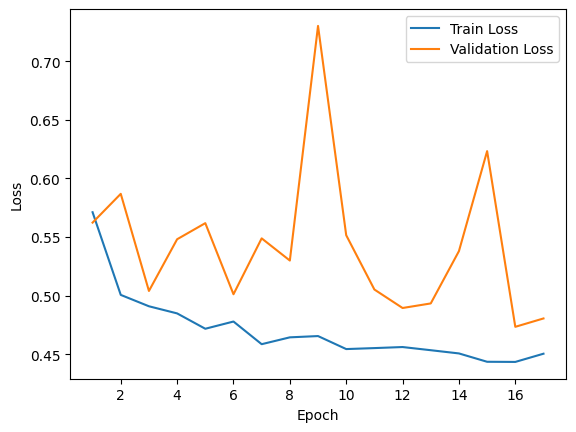

100%|██████████| 893/893 [05:49<00:00,  2.56it/s]


Epoch 18 모델 저장이 완료되었습니다.
Epoch 18, Training Loss: 0.4561447362349789, Training Accuracy: 0.9639688548410436, Validation Loss: 0.5077344083786011, Validation Accuracy: 0.9503908242984694


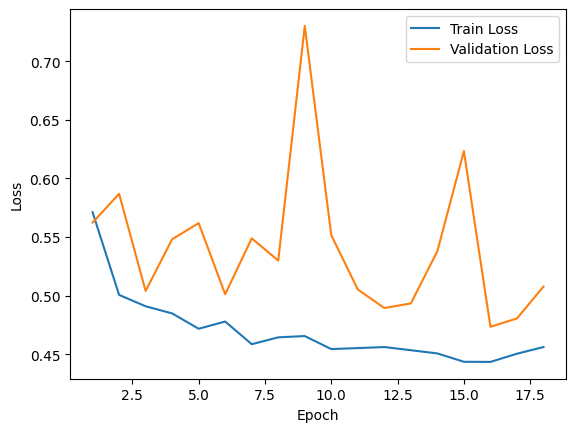

100%|██████████| 893/893 [05:50<00:00,  2.54it/s]


Epoch 19 모델 저장이 완료되었습니다.
Epoch 19, Training Loss: 0.44282561240244284, Training Accuracy: 0.9649163934547033, Validation Loss: 0.48701163053512575, Validation Accuracy: 0.948954081632653


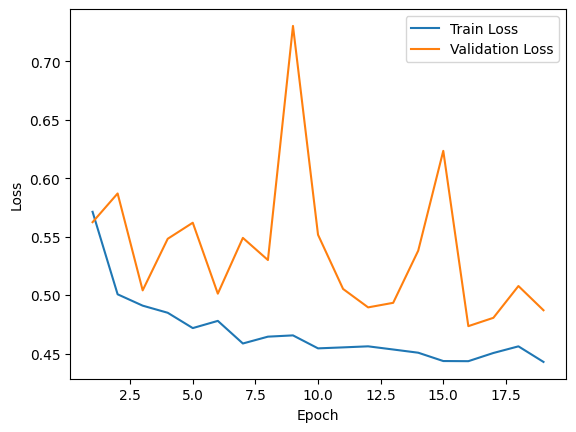

100%|██████████| 893/893 [05:49<00:00,  2.56it/s]


Epoch 20 모델 저장이 완료되었습니다.
Epoch 20, Training Loss: 0.4467011385275028, Training Accuracy: 0.9650838069602841, Validation Loss: 0.5523867726325988, Validation Accuracy: 0.9473258131377551


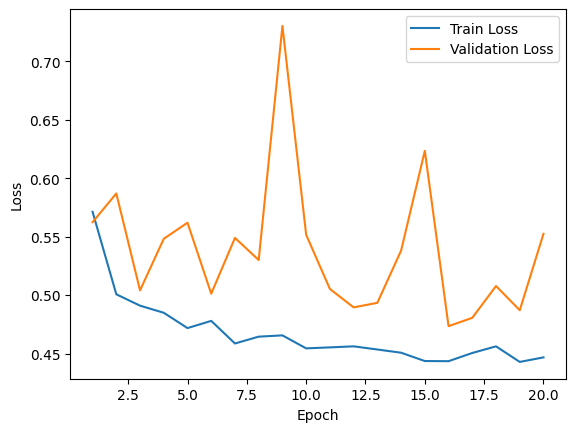

100%|██████████| 893/893 [05:45<00:00,  2.59it/s]


Epoch 21 모델 저장이 완료되었습니다.
Epoch 21, Training Loss: 0.4426628247587571, Training Accuracy: 0.9647493623565497, Validation Loss: 0.5049222493171692, Validation Accuracy: 0.9515015146683673


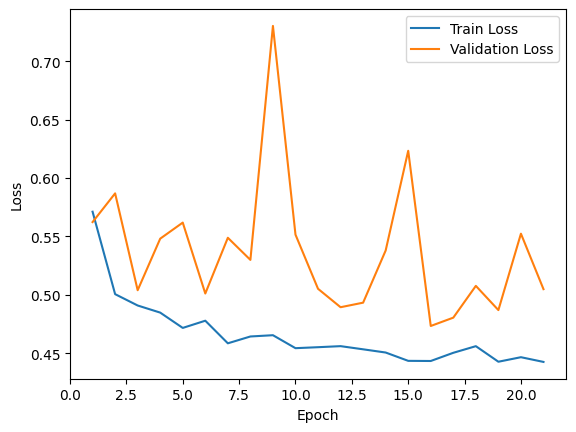

100%|██████████| 893/893 [05:43<00:00,  2.60it/s]


Epoch 22 모델 저장이 완료되었습니다.
Epoch 22, Training Loss: 0.44384676451645666, Training Accuracy: 0.9655049547720874, Validation Loss: 0.4801348984241486, Validation Accuracy: 0.9518927375637755


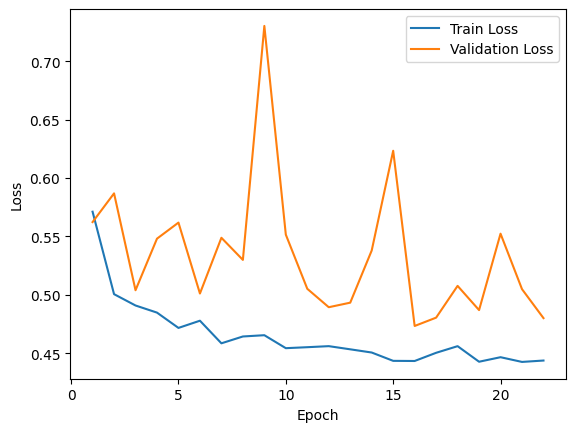

100%|██████████| 893/893 [05:48<00:00,  2.57it/s]


Epoch 23 모델 저장이 완료되었습니다.
Epoch 23, Training Loss: 0.44022001890092255, Training Accuracy: 0.9657261314123864, Validation Loss: 0.5731958055496216, Validation Accuracy: 0.9479765226403061


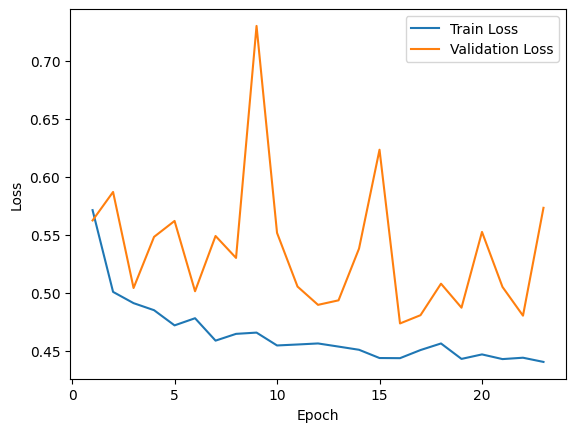

100%|██████████| 893/893 [05:45<00:00,  2.58it/s]


Epoch 24 모델 저장이 완료되었습니다.
Epoch 24, Training Loss: 0.4335972191838908, Training Accuracy: 0.965644469283249, Validation Loss: 0.4921520018577576, Validation Accuracy: 0.9502228156887755


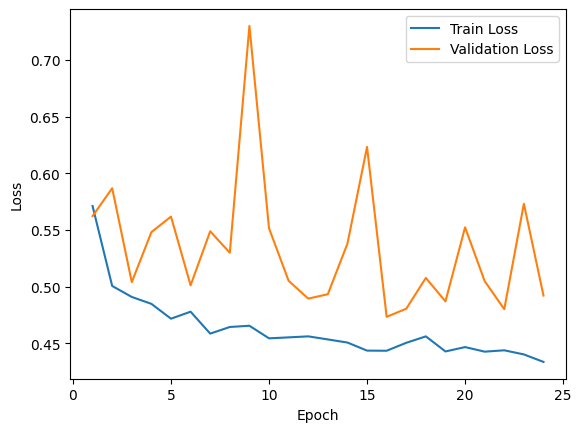

100%|██████████| 893/893 [05:46<00:00,  2.58it/s]


Epoch 25 모델 저장이 완료되었습니다.
Epoch 25, Training Loss: 0.43617404488406547, Training Accuracy: 0.9655822066549834, Validation Loss: 0.48229517698287966, Validation Accuracy: 0.9528583386479592


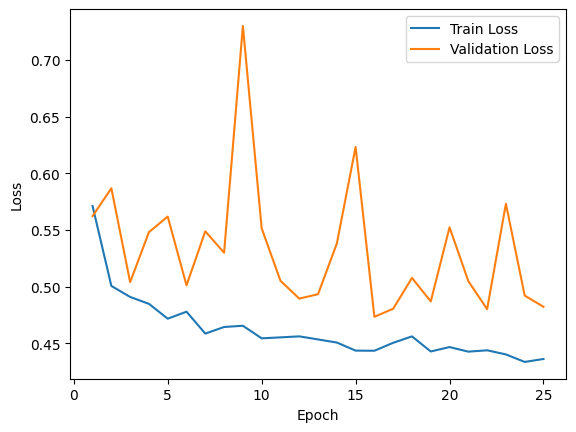

100%|██████████| 893/893 [05:53<00:00,  2.52it/s]


Epoch 26 모델 저장이 완료되었습니다.
Epoch 26, Training Loss: 0.44608599017608874, Training Accuracy: 0.9643416295089464, Validation Loss: 0.4857752013206482, Validation Accuracy: 0.9506931600765306


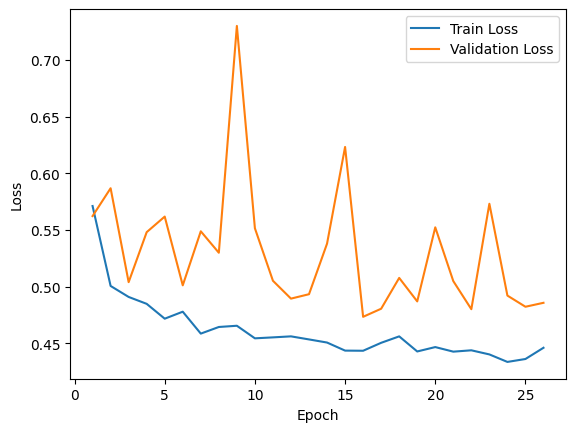

100%|██████████| 893/893 [05:45<00:00,  2.58it/s]


Epoch 27 모델 저장이 완료되었습니다.
Epoch 27, Training Loss: 0.4354887029859013, Training Accuracy: 0.9652001816351541, Validation Loss: 0.4835604953765869, Validation Accuracy: 0.9532973931760204


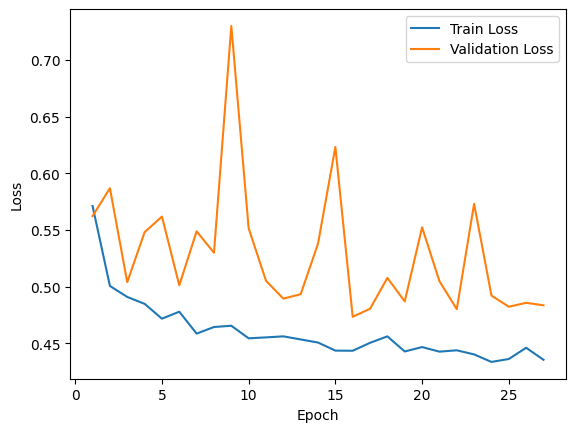

100%|██████████| 893/893 [05:45<00:00,  2.59it/s]


Epoch 28 모델 저장이 완료되었습니다.
Epoch 28, Training Loss: 0.4359575279082056, Training Accuracy: 0.9655842303439233, Validation Loss: 0.47017472982406616, Validation Accuracy: 0.9518309550382653


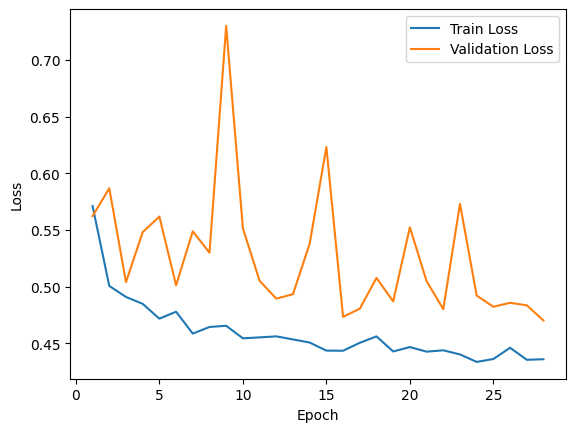

 78%|███████▊  | 696/893 [04:22<01:14,  2.65it/s]


KeyboardInterrupt: 

In [24]:
# # 이전에 저장된 모델을 불러옵니다.
# load_path = "./path/save/v3plus_resnet50/mobileNet_v3plus_resnet50_trained_epoch17.pth"  # 이전에 저장된 모델 파일 경로
# load_model(model, load_path)

for epoch in range(50): # 에폭
    epoch+=1
    model1.train()
    model2.train()
    
    epoch_loss = 0
    correct_pixels_train = 0
    total_pixels_train = 0 
    total_train_f1 = 0  # 전체 학습 데이터에 대한 F1-score의 합

    # 데이터 증강을 위한 transform 파이프라인 정의
    trainTransform = A.Compose(
        [
            A.RandomCrop(224,224),  # 랜덤 자르기
            A.RandomRotate90(),  # 90도 회전 (랜덤하게)
            A.HorizontalFlip(p=0.5),  # 수평 뒤집기 확률 50%
            A.VerticalFlip(p=0.5),  # 수직 뒤집기 확률 50%
            A.CLAHE(p=0.2),  # CLAHE를 통한 대비 개선

            A.Resize(224, 224),  # 이미지 크기 조정
            # A.Normalize(),  # 이미지 픽셀값 정규화
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 이미지 픽셀값 정규화
            ToTensorV2()  # 이미지를 텐서로 변환
        ]
    )
    valTransform = A.Compose(
        [
            A.RandomCrop(224,224),  # 랜덤 자르기
            A.RandomRotate90(),  # 90도 회전 (랜덤하게)
            A.HorizontalFlip(p=0.5),  # 수평 뒤집기 확률 50%
            A.VerticalFlip(p=0.5),  # 수직 뒤집기 확률 50%
            A.CLAHE(p=0.2),  # CLAHE를 통한 대비 개선

            A.Resize(224, 224),  # 이미지 크기 조정
            # A.Normalize(),  # 이미지 픽셀값 정규화
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 이미지 픽셀값 정규화
            ToTensorV2()  # 이미지를 텐서로 변환
        ]
    )
    
    dataset = SatelliteDataset(csv_file='./train.csv', transform=trainTransform) # dataset 불러오기
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    validation_dataset = SatelliteDataset(csv_file='./validation.csv', transform=valTransform)  # validation 데이터셋 로딩
    validation_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=True)

    for images, masks in tqdm(dataloader):
        # GPU 디바이스로 데이터 이동
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer1.zero_grad()
        optimizer2.zero_grad()

        # 각 모델에 입력 이미지를 전달하여 출력 얻기
        outputs1 = model1(images)
        outputs2 = model2(images)

        # 모델 출력을 평균하여 앙상블한 손실 계산
        ensembled_outputs = (outputs1 + outputs2) / 2.0
        loss = criterion(ensembled_outputs, masks.unsqueeze(1))
        
        loss.backward() # 역전파를 통해 모델의 파라미터에 대한 손실 함수의 기울기(gradient)를 계산
        optimizer1.step() # 옵티마이저를 사용하여 모델의 파라미터를 업데이트
        optimizer2.step() # 옵티마이저를 사용하여 모델의 파라미터를 업데이트

        epoch_loss += loss.item() # 학습 과정에서 전체 에포크의 손실을 계산하기 위해 사용

        # 정확도 계산
        predicted_masks_train = (torch.sigmoid(ensembled_outputs) > 0.5).float()
        correct_pixels_train += (predicted_masks_train == masks.unsqueeze(1)).sum().item()
        total_pixels_train += masks.numel()
        # total_train_f1 += calculate_f1_score(outputs, masks)

    epoch_loss /= len(dataloader)
    accuracy_train = correct_pixels_train / total_pixels_train
    # average_train_f1 = total_train_f1 / len(dataloader.dataset)

    # Validation 과정
    model1.eval()
    model2.eval()
    total_val_loss = 0.0
    correct_pixels_val = 0
    total_pixels_val = 0
    total_val_f1 = 0  # 전체 검증 데이터에 대한 F1-score의 합

    with torch.no_grad():  # 그라디언트 계산 비활성화
        for val_images, val_masks in validation_dataloader:
            val_images = val_images.float().to(device)
            val_masks = val_masks.float().to(device)

            val_outputs1 = model1(val_images)
            val_outputs2 = model2(val_images)

            ensembled_val_outputs = (val_outputs1 + val_outputs2) / 2.0
            val_loss = criterion(ensembled_val_outputs, val_masks.unsqueeze(1))

            total_val_loss += val_loss.item() * val_images.size(0)

            # 정확도 계산
            predicted_masks_val = (torch.sigmoid(ensembled_val_outputs) > 0.5).float()
            correct_pixels_val += (predicted_masks_val == val_masks.unsqueeze(1)).sum().item()
            total_pixels_val += val_masks.numel()
            # total_val_f1 += calculate_f1_score(val_outputs, val_masks)

    average_validation_loss = total_val_loss / len(validation_dataset)
    accuracy_val = correct_pixels_val / total_pixels_val
    # average_val_f1 = total_val_f1 / len(validation_dataloader.dataset)

    # 각 에폭이 끝날 때마다 모델 저장
    save_path_model1 = save_dir + f"model1_epoch_{epoch}.pth"
    save_path_model2 = save_dir + f"model2_epoch_{epoch}.pth"
    torch.save(model1.state_dict(), save_path_model1)
    torch.save(model2.state_dict(), save_path_model2)
    print(f"Epoch {epoch} 모델 저장이 완료되었습니다.")

    # 훈련 및 검증 결과 출력
    print(f'Epoch {epoch}, Training Loss: {epoch_loss}, Training Accuracy: {accuracy_train}, Validation Loss: {average_validation_loss}, Validation Accuracy: {accuracy_val}')    
    
    train_losses.append(epoch_loss)
    val_losses.append(average_validation_loss)

    # Convert the loss values to numpy arrays using .cpu() method
    train_losses_np = torch.tensor(train_losses).cpu().numpy()
    val_losses_np = torch.tensor(val_losses).cpu().numpy()

    # Plot the losses after each epoch
    plt.plot(range(1, len(train_losses_np) + 1), train_losses_np, label='Train Loss')
    plt.plot(range(1, len(val_losses_np) + 1), val_losses_np, label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Transform Define

In [ ]:
# albumentations 라이브러리를 사용하여 이미지 데이터에 대한 변환(transform) 파이프라인 정의
transform = A.Compose(
    [
        A.Resize(224, 224), # 이미지 크기 조정
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 이미지 픽셀값 정규화
        ToTensorV2() # 이미지를 텐서로 변환
    ]
)

# Test Data Loader

In [ ]:
test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
print(len(test_dataset))
print(len(test_dataloader))

60640
7580


# Load Model

In [ ]:
# 모델 생성
model = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=False,num_classes=1)

# 저장된 모델의 파라미터 불러오기 (strict=False 옵션 사용)
state_dict = torch.load('./path/save/v3_mobilenet/mobileNet_focal_dice_trained_epoch23.pth', map_location=torch.device('cpu'))

# 저장된 모델의 클래스 수 (1개의 클래스일 때)
saved_num_classes = 1

# 현재 모델의 클래스 수 (예시로 21로 설정, 실제 사용하는 클래스 수로 수정)
current_num_classes = 1

# 모델의 분류기 레이어 크기 변경
if saved_num_classes != current_num_classes:
    # 모델의 분류기 레이어를 1x1 컨볼루션 레이어로 수정
    model.classifier[4] = torch.nn.Conv2d(256, current_num_classes, kernel_size=(1, 1), stride=(1, 1))
    # 모델의 분류기 레이어를 초기화
    torch.nn.init.xavier_uniform_(model.classifier[4].weight)  # 또는 다른 초기화 방법 사용

# 모델의 파라미터 로드
model.load_state_dict(state_dict, strict=False)

# GPU 사용이 가능한 경우에는 GPU로 데이터 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 

# Inference

In [ ]:
# 결과를 저장할 리스트 초기화
result = []

with torch.no_grad(): # 역전파 비활성화, 파라미터 업데이트 금지
    # print(len(test_dataloader))
    for images in tqdm(test_dataloader): # 데이터 로드
        images = images.float().to(device) 

        outputs = model(images)['out'] # 테스트 이미지 전달하여 예측 결과 얻음
        masks = torch.sigmoid(outputs).cpu().numpy() # outputs는 모델 예측 결과, 확률값으로 변환하기 위해 시그모이드 함수 적용한 후 각 픽셀 값을 0과 1사이의 확률값으로 변환하고, 넘파이 배열로 변환
        masks = np.squeeze(masks, axis=1) # 불필요한 차원 제거
        masks = (masks > 0.35).astype(np.uint8) # 최종 이진화 예측 마스크 얻음
        
        # print(len(images))
        for i in range(len(images)):
            mask_rle = rle_encode(masks[i]) # RLE로 변환, mask_rle에 인코딩 결과 저장
            if mask_rle == '':
                result.append(-1) # 빌딩 없으면 -1 저장
            else:
                result.append(mask_rle) # 아니면 mask_rle 저장

            visualized_image = images[i].cpu().numpy().transpose((1, 2, 0)) # 이미지 시각화하기 위해 넘파이 배열로 가져옴
            masks_visualized = masks[i] * 255 # 이진화 마스크로 변환

            # plt.subplot(1, 2, 1)
            # plt.imshow(visualized_image)
            # plt.title("Input Image")

            # plt.subplot(1, 2, 2)
            # plt.imshow(masks_visualized, cmap='gray')
            # plt.title("Predicted Mask")

            # plt.show()

100%|██████████| 7580/7580 [08:22<00:00, 15.09it/s]


In [ ]:
print(len(result))

60640


# Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

In [ ]:
submit.to_csv('./submit.csv', index=False)